# Deformable Attention

Welcome to the **Deformable Attention** workshop. In this workshop, we'll see how to 
- Build a Deformable attention module, step by step
- See how its integrated in Deformable Attention Tranformer architecture
- Visualize the Attention results on sample images  

We'll first install and import certain modules that we need

In [ ]:
## pip install natten, timm, einops

# Imports

In [1]:
import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_

/home/surya/miniconda3/envs/dat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

Input images are processed by Patch embedding module, before passed on to the Transformer blocks. Assuming a input RGB image of 224x224 size and `DAT tiny` architecture, the output of module is (1, 64, 56, 56)

We'll define some constants, related to attention module in first stage of Transformer block

In [2]:
q_size = (56, 56)     # input feature map height, width
n_heads = 2           # number of attention heads
n_head_channels = 32  # channel per head
n_groups = 1          # depth wise convolution for efficiency
ksize = 9             # kernel size for offset 
stride = 8            

#### TODO: ADD DA arch image here

As you can see in above image, there are different components in Deformable Attention module such as:
- Reference grid generation
- Offset Generation network
- Calculating sampled features
- Attention mechanism
- Relative Position Embedding

## Reference grid generation

- Equally spaced 2D grid points are generated based on input feature map size. We'll make use of torch.meshgrid() function.
- Inputs
    - h_grid, w_grid, batch_size
    - n_groups
- Outputs
    - (1, batch_size, h_grid, w_grid) tensor, equally spaced points

In [3]:
def get_reference_points(h_grid, w_grid, bs, n_groups):
    ref_y, ref_x = torch.meshgrid(
        torch.linspace(0.5, h_grid - 0.5, h_grid),
        torch.linspace(0.5, w_grid - 0.5, w_grid),
        indexing='ij'
    )
    ref = torch.stack((ref_y, ref_x), -1)
    ref[..., 1].div_(w_grid - 1.0).mul_(2.0).sub_(1.0)
    ref[..., 0].div_(h_grid - 1.0).mul_(2.0).sub_(1.0)
    ref = ref[None, ...].expand(bs * n_groups, -1, -1, -1) # B * g H W 2
    return ref

In [4]:
ref_grid_pts = get_reference_points(h_grid=7,  w_grid=7, bs=1, n_groups=1)
print(ref_grid_pts.shape)
ref_grid_pts = ref_grid_pts.detach().cpu().numpy()

torch.Size([1, 7, 7, 2])


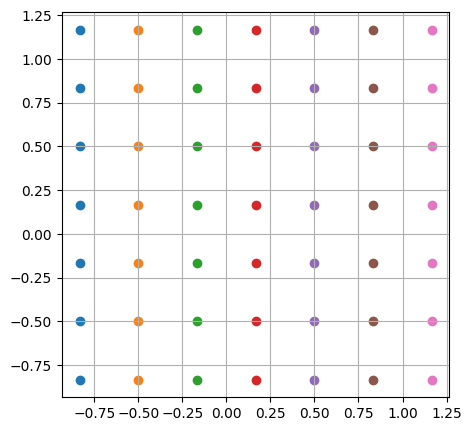

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
for r in range(7):
    plt.scatter(ref_grid_pts[0, r, :, 0], ref_grid_pts[0, r, :, 1])
plt.grid(True)

## Offset prediction network

TODO: Add picture

We'll first define a LayerNorm network, that accepts inputs of (bs, c, h, w) shape and outputs the same shaep, but applies a Layer Normalization inbetween. 

In [6]:
class LayerNormModule(nn.Module):
    def __init__(self, dim):    
        super().__init__()
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        x = einops.rearrange(x, 'b c h w -> b h w c')
        x = self.norm(x)
        return einops.rearrange(x, 'b h w c -> b c h w')

The Conv modules, use Depth wise convolution for efficiency. This is specified using groups parameter in Pytorch. The groups are split b/w different heads. We'll define the renmaining layers as follows:

In [7]:
# stage 0, group channels
n_group_channels = 64

offset_generation_network = nn.Sequential(
            nn.Conv2d(n_group_channels, n_group_channels, kernel_size=ksize, stride=stride, 
                      padding = ksize // 2, groups=n_group_channels),
            LayerNormModule(n_group_channels),
            nn.GELU(),
            nn.Conv2d(n_group_channels, 2, 1, 1, 0, bias=False)
        )

In [8]:
test_input_data = torch.Tensor(1, 64, 56, 56)
offset = offset_generation_network(test_input_data)
print(offset.shape)

# outputs have channel size of 2, we can bring it to last dimension
offset = einops.rearrange(offset, 'b p h w -> b h w p')
print(offset.shape)

torch.Size([1, 2, 7, 7])
torch.Size([1, 7, 7, 2])


## Calculating sampled features

Now that we have the reference points and the offsets. So, the final position is sum of 

## Attention mechanism

## Relative Position Embedding

## Putting it altogether

In [ ]:
class DAttentionBaseline(nn.Module):
    def __init__(self, q_size, kv_size, n_heads, n_head_channels, n_groups,
        attn_drop, proj_drop, stride,
        no_off, ksize):

        super().__init__()
        self.n_head_channels = n_head_channels
        self.scale = self.n_head_channels ** -0.5
        self.n_heads = n_heads
        self.q_h, self.q_w = q_size
        self.kv_h, self.kv_w = self.q_h // stride, self.q_w // stride
        self.nc = n_head_channels * n_heads
        self.n_groups = n_groups
        self.n_group_channels = self.nc // self.n_groups
        self.n_group_heads = self.n_heads // self.n_groups
        self.no_off = no_off
        self.ksize = ksize
        self.stride = stride
        kk = self.ksize
        pad_size = kk

        self.conv_offset = nn.Sequential(
            nn.Conv2d(self.n_group_channels, self.n_group_channels, kk, stride, pad_size, groups=self.n_group_channels),
            LayerNormProxy(self.n_group_channels),
            nn.GELU(),
            nn.Conv2d(self.n_group_channels, 2, 1, 1, 0, bias=False)
        )

        self.proj_q = nn.Conv2d(self.nc, self.nc,kernel_size=1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)
        self.proj_out = nn.Conv2d(self.nc, self.nc, kernel_size=1, stride=1, padding=0)

        self.proj_drop = nn.Dropout(proj_drop, inplace=True)
        self.attn_drop = nn.Dropout(attn_drop, inplace=True)

        self.rpe_table = nn.Parameter(
            torch.zeros(self.n_heads, self.q_h * 2 - 1, self.q_w * 2 - 1)
        )
        trunc_normal_(self.rpe_table, std=0.01)

    @torch.no_grad()
    def _get_ref_points(self, H_key, W_key, B, dtype, device):

        ref_y, ref_x = torch.meshgrid(
            torch.linspace(0.5, H_key - 0.5, H_key, dtype=dtype, device=device),
            torch.linspace(0.5, W_key - 0.5, W_key, dtype=dtype, device=device),
            indexing='ij'
        )
        ref = torch.stack((ref_y, ref_x), -1)
        ref[..., 1].div_(W_key - 1.0).mul_(2.0).sub_(1.0)
        ref[..., 0].div_(H_key - 1.0).mul_(2.0).sub_(1.0)
        ref = ref[None, ...].expand(B * self.n_groups, -1, -1, -1) # B * g H W 2

        return ref
    
    @torch.no_grad()
    def _get_q_grid(self, H, W, B, dtype, device):

        ref_y, ref_x = torch.meshgrid(
            torch.arange(0, H, dtype=dtype, device=device),
            torch.arange(0, W, dtype=dtype, device=device),
            indexing='ij'
        )
        ref = torch.stack((ref_y, ref_x), -1)
        ref[..., 1].div_(W - 1.0).mul_(2.0).sub_(1.0)
        ref[..., 0].div_(H - 1.0).mul_(2.0).sub_(1.0)
        ref = ref[None, ...].expand(B * self.n_groups, -1, -1, -1) # B * g H W 2

        return ref

    def forward(self, x):

        B, C, H, W = x.size()
        dtype, device = x.dtype, x.device

        q = self.proj_q(x)
        q_off = einops.rearrange(q, 'b (g c) h w -> (b g) c h w', g=self.n_groups, c=self.n_group_channels)
        offset = self.conv_offset(q_off).contiguous()  # B * g 2 Hg Wg
        Hk, Wk = offset.size(2), offset.size(3)
        n_sample = Hk * Wk

        offset = einops.rearrange(offset, 'b p h w -> b h w p')
        reference = self._get_ref_points(Hk, Wk, B, dtype, device)

        pos = (offset + reference).clamp(-1., +1.)

        x_sampled = F.grid_sample(
            input=x.reshape(B * self.n_groups, self.n_group_channels, H, W), 
            grid=pos[..., (1, 0)], # y, x -> x, y
            mode='bilinear', align_corners=True) # B * g, Cg, Hg, Wg
                

        x_sampled = x_sampled.reshape(B, C, 1, n_sample)

        q = q.reshape(B * self.n_heads, self.n_head_channels, H * W)
        k = self.proj_k(x_sampled).reshape(B * self.n_heads, self.n_head_channels, n_sample)
        v = self.proj_v(x_sampled).reshape(B * self.n_heads, self.n_head_channels, n_sample)

        attn = torch.einsum('b c m, b c n -> b m n', q, k) # B * h, HW, Ns
        attn = attn.mul(self.scale)


        rpe_table = self.rpe_table
        rpe_bias = rpe_table[None, ...].expand(B, -1, -1, -1)
        q_grid = self._get_q_grid(H, W, B, dtype, device)
        displacement = (q_grid.reshape(B * self.n_groups, H * W, 2).unsqueeze(2) - pos.reshape(B * self.n_groups, n_sample, 2).unsqueeze(1)).mul(0.5)
        attn_bias = F.grid_sample(
            input=einops.rearrange(rpe_bias, 'b (g c) h w -> (b g) c h w', c=self.n_group_heads, g=self.n_groups),
            grid=displacement[..., (1, 0)],
            mode='bilinear', align_corners=True) # B * g, h_g, HW, Ns

        attn_bias = attn_bias.reshape(B * self.n_heads, H * W, n_sample)
        attn = attn + attn_bias

        attn = F.softmax(attn, dim=2)
        attn = self.attn_drop(attn)

        out = torch.einsum('b m n, b c n -> b c m', attn, v)

        out = out.reshape(B, C, H, W)

        y = self.proj_drop(self.proj_out(out))

        return y, pos.reshape(B, self.n_groups, Hk, Wk, 2), reference.reshape(B, self.n_groups, Hk, Wk, 2)

In [ ]:
# (Batch size, RGB channels, height, width)
input_data = torch.Tensor(1, 3, img_size, img_size)
patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=embed_dim)
patch_embed_output = patch_embed(input_data)
print(f"Patch embedding output shape = {patch_embed_output.shape}")

## Deformable Attention Transformer Architecture

## Visualize Attention

We'll load a pretrained model, and visualized the output on sample images

In [ ]:
checkpt = torch.load('/home/surya/Downloads/dino_deitsmall16_pretrain_full_checkpoint.pth')['student']
state_dict = {k.replace("module.", ""): v for k, v in checkpt.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}


In [ ]:
state_dict = {k:v for k, v in state_dict.items() if 'head.' not in k}

In [ ]:
# from PIL import Image

# with open('../assets/test_image.jpg', 'rb') as f:
#     img = Image.open(f)
#     img = img.convert('RGB')

In [ ]:
# from torchvision import transforms as pth_transforms

In [ ]:
# transform = pth_transforms.Compose([
#     pth_transforms.Resize([224, 224]),
#     pth_transforms.ToTensor(),
#     pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
# ])
# img = transform(img)

In [ ]:
# img.shape

In [ ]:
# # make the image divisible by the patch size
# w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
# img = img[:, :w, :h].unsqueeze(0)

# w_featmap = img.shape[-2] // patch_size
# h_featmap = img.shape[-1] // patch_size

# _, attentions = vit(img)

In [ ]:
# attentions.shape

In [ ]:
# # nh = attentions.shape[1] # number of head

# # we keep only the output patch attention
# attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

In [ ]:
# attentions.shape

In [ ]:
# attentions = attentions.reshape(nh, w_featmap, h_featmap)
# attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].detach().cpu().numpy()

In [ ]:
# attentions.shape

In [ ]:
# output_dir = 'output'

In [ ]:
import os

In [ ]:
import torchvision

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# # save attentions heatmaps
# os.makedirs(output_dir, exist_ok=True)
# torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(output_dir, "img.png"))
# for j in range(nh):
#     fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
#     plt.imsave(fname=fname, arr=attentions[j], format='png')
#     print(f"{fname} saved.")

In [ ]:
# torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(args.output_dir, "img.png"))

In [ ]:





#     # save attentions heatmaps
#     os.makedirs(args.output_dir, exist_ok=True)
#     torchvision.utils.save_image(torchvision.utils.make_grid(img, normalize=True, scale_each=True), os.path.join(args.output_dir, "img.png"))
#     for j in range(nh):
#         fname = os.path.join(args.output_dir, "attn-head" + str(j) + ".png")
#         plt.imsave(fname=fname, arr=attentions[j], format='png')
#         print(f"{fname} saved.")

#     if args.threshold is not None:
#         image = skimage.io.imread(os.path.join(args.output_dir, "img.png"))
#         for j in range(nh):
#             display_instances(image, th_attn[j], fname=os.path.join(args.output_dir, "mask_th" + str(args.threshold) + "_head" + str(j) +".png"), blur=False)


## References
- [DAT++: Spatially Dynamic Vision Transformer with Deformable Attention](https://arxiv.org/pdf/2309.01430)